## Normalization

### Initialization

In [ ]:
%% Author: Lu, Chia-Feng 2013.10.23
clear, close all

%% initialize parameters
selectchannel=20; % channel 20 is Cz
baselinelength=300; % in data point the points before the event

### Load Data

The EEG and EMG signals are collected, while the subject stands on a balance beam tring to regain balance when perturbation events triggerd. The channel 20 of the EEG is analysised. The alpha and beta are pre-processed two signal bands on 8-12 Hz and 15-20 Hz respectively. ind is time stamp of the perturbation event.

epochnum is the number of events.

EMGdata: 6268808x2
fdata_alpha: 6268808x34
fdata_beata: 6268808x34



In [ ]:
load('EEGdata.mat')

epochnum=length(ind);
channelNo=size(fdata_alpha,2);

### Normalize data

Normalize both alpha band and beta band, Use mean data as the baseline

$$
E R D / E R S(\%)=\frac{\text { Signal }_{\text {power }}-\text { baseline }_{\text {power }}}{\text { baseline }_{\text {power }}} \times 100 \%
$$

In [ ]:
%% EEG epoch data
for band=1:2
    if band==1
        ffdata=fdata_alpha;  % alpha band
    elseif band==2
        ffdata=fdata_beta;   % beta band
    end
    
    %%% cut epoch
    epoch=zeros(epochnum,1000+baselinelength,channelNo);
    for i=1:epochnum
        epoch(i,:,:)=ffdata(ind(i)-baselinelength:ind(i)+1000-1,:);
    end
    
    %%% calculate ERD/ERS
    for i=1:epochnum       % for ith trial
        for j=1:channelNo  % jth channel
            y(i,:,j)= (epoch(i,:,j)-mean(epoch(:,:,j),1)).^2;
            y(i,:,j)= y(i,:,j)/mean(y(i,1:baselinelength,j))*100;
        end
    end
    
    if band==1
        ER_alpha=squeeze(mean(y,1)); % mean on dim 1 (trials)
    elseif band==2
        ER_beta=squeeze(mean(y,1));
    end
end


### Plot
Plot the normalized and averaged data on both alpha and beta bands with the tigger event

In [ ]:

%% plot results of selected channel
figure,

% sooth() function is moving averaging the data with a window lenth 

tmp_alpha=smooth(ER_alpha(:,selectchannel),50);
tmp_beta=smooth(ER_beta(:,selectchannel),50);

% tmp_alpha=ER_alpha(:,selectchannel);
% tmp_beta=ER_beta(:,selectchannel);


plot(tmp_alpha,'color','b'),hold on,
plot(tmp_beta,'color','r')
plot([baselinelength baselinelength],[min([tmp_alpha; tmp_beta])-100 max([tmp_alpha; tmp_beta])],'r')
title(chlabel{selectchannel})

## Event Detection

### Initialization

In [1]:
%% Author: Lu, Chia-Feng 2013.10.23
clear, close all

%% initialize parameters
DispCh = 2;   % select a channel to display  
SampleRate = 2000; % in Hz

Res_MagThres = 1; % the threshold of res. band magnitude

EMG_BPcutooff = [70 500];  % cutoff frequency of bandpass filter, in Hz
EMG_Lcutoff = 4;           % cutoff frequency of lowpass filter, in Hz


### Load Data

Reperation data (Resdata) and the corresponding EMG data (EMGdata) are collected.

* EMGdata in channel 1-4
* Resdata in channel 5



In [2]:
load('EMGdata.mat')
% data is size of timepoints*channels(4 EMG and 1 respration band)
EMGdata=data(:,1:4);
Resdata=data(:,5);


### Peak value detect

1. Remove DC offset by substract the mean value below 0
2. Use threshold_1 to get the data above the threshold.
3. Get gap index
4. Get maxium index of the original data skip gaps
> pay attention to the boundary conditions


In [3]:
%% detect the peak value of each resp. cycle using signal of resp. band
oResdata=Resdata-mean(Resdata(find(Resdata<0))); % remove DC offset

%%% perform double-threshold method to detect peak value
% threshold 1: magnitude
indmag=find(oResdata>=1);    % find the index with value larger than 1

% threshold 2: define window
diffind=indmag(2:end)-indmag(1:end-1);
indgap=find(diffind>1);

indmax=[];   % the location of index with maximal value in each cycle
for i=1:length(indgap)+1
    if i==1
        period=indmag(1:indgap(1));
    elseif i==length(indgap)+1    
        period=indmag(indgap(i-1)+1:end);
    else
        period=indmag(indgap(i-1)+1:indgap(i));
    end
    [value,ind]=max(oResdata(period));
    indmax(i)=period(ind(1));
end

### Bandpass filtering the data

In [4]:
%% bandpass filter, rectify, lowpass filter
fEMGdata=filter_proc(EMGdata',SampleRate,EMG_BPcutooff,3)';       % bandpass filter 
rfEMGdata=abs(fEMGdata);                                          % rectify
frfEMGdata=filter_proc(rfEMGdata',SampleRate,EMG_Lcutoff,1)';     % lowpass filter 
pfrfEMGdata=frfEMGdata(:,DispCh)/max(frfEMGdata(:,DispCh))*100;   % percentage

### Plot the data

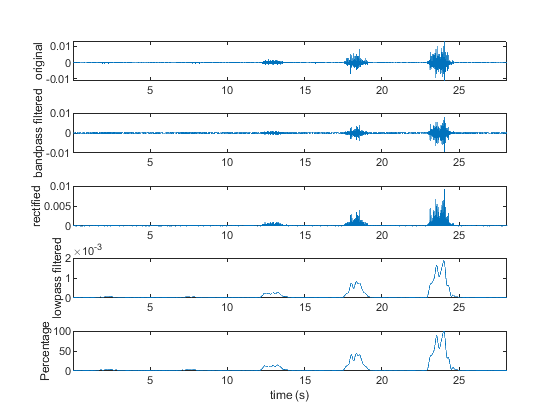

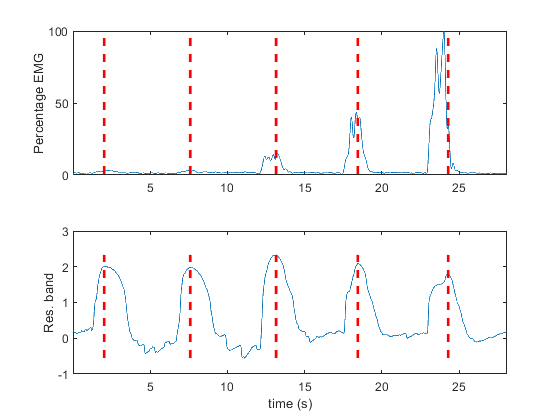

In [5]:
%% plot the processed signals
taxis = [1:size(data,1)]/SampleRate; % define the time axis based on the data length and sampling rate

figure, 
subplot(5,1,1),plot(taxis,EMGdata(:,DispCh)) % original signal
ylabel('original'),xlim([min(taxis) max(taxis)])
subplot(5,1,2),plot(taxis,fEMGdata(:,DispCh)) % bandpass filtered signal
ylabel('bandpass filtered'),xlim([min(taxis) max(taxis)])
subplot(5,1,3),plot(taxis,rfEMGdata(:,DispCh)) % rectified signal
ylabel('rectified'),xlim([min(taxis) max(taxis)])
subplot(5,1,4),plot(taxis,frfEMGdata(:,DispCh)) % lowpass filtered signal
ylabel('lowpass filtered'),xlim([min(taxis) max(taxis)])
subplot(5,1,5),plot(taxis,pfrfEMGdata) % percentage signal
ylabel('Percentage'),xlabel('time (s)'),xlim([min(taxis) max(taxis)])

figure, 
subplot(2,1,1),plot(taxis,pfrfEMGdata), hold on
for i=1:length(indmax)
    plot([taxis(indmax(i)) taxis(indmax(i))],[min(pfrfEMGdata) max(pfrfEMGdata)],'r--','linewidth',2) % plot the location of index with maximal value in each cycle 
end
ylabel('Percentage EMG'),xlim([min(taxis) max(taxis)])
subplot(2,1,2),plot(taxis,oResdata),hold on, %plot(taxis,Resdata,'r')
for i=1:length(indmax)
    plot([taxis(indmax(i)) taxis(indmax(i))],[min(oResdata) max(oResdata)],'r--','linewidth',2)       % plot the location of index with maximal value in each cycle
end
ylabel('Res. band'),xlabel('time (s)'),xlim([min(taxis) max(taxis)])